In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import calendar # To get month names

In [2]:
# --- 2. Define Paths and Load the Dataset ---
PROJECT_ROOT = Path("../")
FLOW_DATA_DIR = PROJECT_ROOT / "data" / "flow"

# Input file path for the complete flow record
ALL_FLOW_CSV = FLOW_DATA_DIR / "all_flows.csv"

# Load the discharge (flow) data
try:
    df_flow = pd.read_csv(ALL_FLOW_CSV, parse_dates=['Date'], index_col='Date')
    print("Full flow dataset loaded successfully.")
    print("--- Initial Data Info ---")
    df_flow.info()
    print("\n--- Data Head ---")
    print(df_flow.head())
except FileNotFoundError:
    print(f"ERROR: Flow data not found at {ALL_FLOW_CSV}")

Full flow dataset loaded successfully.
--- Initial Data Info ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40099 entries, 1915-03-15 to 2024-12-31
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Discharge  35616 non-null  float64
dtypes: float64(1)
memory usage: 626.5 KB

--- Data Head ---
            Discharge
Date                 
1915-03-15   8.628715
1915-03-16        NaN
1915-03-17        NaN
1915-03-18        NaN
1915-03-19        NaN


In [3]:
# --- 3. Clean and Preprocess the Flow Data ---

# Step 1: Ensure the 'Discharge' column is numeric. `errors='coerce'` will
# turn any non-numeric values (like blanks) into NaN (Not a Number).
df_flow['Discharge'] = pd.to_numeric(df_flow['Discharge'], errors='coerce')

# Step 2: Interpolate missing values.
# River flow is a continuous process, so it's reasonable to fill short gaps
# using linear interpolation. This draws a straight line between the known points.
print(f"\nNumber of missing values before interpolation: {df_flow['Discharge'].isnull().sum()}")
df_flow['Discharge'].interpolate(method='linear', inplace=True)
print(f"Number of missing values after interpolation: {df_flow['Discharge'].isnull().sum()}")

# Note: Interpolation can't fill NaNs at the very start or end of the series.
# We will drop these if they exist to ensure a clean dataset.
df_flow.dropna(inplace=True)

print("\n--- Cleaned and Interpolated Data Info ---")
df_flow.info()
print("\n--- Cleaned Data Head ---")
print(df_flow.head(15))


Number of missing values before interpolation: 4483
Number of missing values after interpolation: 0

--- Cleaned and Interpolated Data Info ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40099 entries, 1915-03-15 to 2024-12-31
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Discharge  40099 non-null  float64
dtypes: float64(1)
memory usage: 626.5 KB

--- Cleaned Data Head ---
            Discharge
Date                 
1915-03-15   8.628715
1915-03-16   9.433801
1915-03-17  10.238888
1915-03-18  11.043974
1915-03-19  11.849060
1915-03-20  12.654146
1915-03-21  13.459233
1915-03-22  14.264319
1915-03-23  15.069405
1915-03-24  15.874491
1915-03-25  16.679578
1915-03-26  17.484664
1915-03-27  18.289750
1915-03-28  18.289750
1915-03-29  18.494650


C:\Users\alex.huang\AppData\Local\Temp\ipykernel_36344\2585671277.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_flow['Discharge'].interpolate(method='linear', inplace=True)


In [10]:
# --- 4. Find the Date and Value of Each Year's Peak Flow ---

# Step 1: Find the index (date) of the maximum discharge for each year.
# This part is the same as before.
peak_flow_dates = df_flow.groupby(df_flow.index.year)['Discharge'].idxmax()

# Step 2: Use these dates to select the full rows from the original DataFrame.
# The .loc accessor is perfect for selecting rows based on index labels (our dates).
peak_flow_events = df_flow.loc[peak_flow_dates]

# Step 3: Add a 'Year' column for clarity, extracted from the date index.
peak_flow_events['Year'] = peak_flow_events.index.year

# Step 4: Reorder the columns to be more intuitive.
peak_flow_events = peak_flow_events[['Year', 'Discharge']]


print("--- Annual Peak Flow Events (Date and Discharge Value) ---")

# To ensure all rows are printed without being truncated, we can use pandas' options.
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(peak_flow_events)

--- Annual Peak Flow Events (Date and Discharge Value) ---
            Year   Discharge
Date                        
1915-10-29  1915   42.467950
1916-06-17  1916  222.267700
1917-05-29  1917  175.140700
1918-06-10  1918  176.165200
1919-05-26  1919  152.601700
1920-06-01  1920   90.107200
1921-06-07  1921  203.826700
1922-06-04  1922  201.777700
1923-01-01  1923   12.274470
1924-01-01  1924   11.906839
1925-01-01  1925   11.538202
1926-01-01  1926   11.170571
1927-01-01  1927   10.802940
1928-01-01  1928   10.435310
1929-01-01  1929   10.066672
1930-01-01  1930    9.699042
1931-01-01  1931    9.331411
1932-01-01  1932    8.963781
1933-01-01  1933    8.595143
1934-11-06  1934   90.107200
1935-01-25  1935  153.626200
1936-05-31  1936  143.381200
1937-06-03  1937  185.385700
1938-05-25  1938  182.312200
1939-05-16  1939  155.675200
1940-05-24  1940   83.960200
1941-12-03  1941   88.058200
1942-05-26  1942  123.915700
1943-05-27  1943  154.650700
1944-05-29  1944   72.076000
1945-05-31  1

In [5]:
# --- 5. Count the Occurrences of Peak Flows in Each Month ---

# The result from the previous step is a Series of dates. We can access the
# month of each date using the `.dt.month` accessor.
peak_months = peak_flow_dates.dt.month

# Now, we use `value_counts()` to count how many times each month appears.
peak_month_counts = peak_months.value_counts().sort_index()

# Let's map the month numbers (1-12) to month names for clarity.
peak_month_counts.index = peak_month_counts.index.map(lambda x: calendar.month_abbr[x])


print("--- Frequency of Annual Peak Flow by Month ---")
print(peak_month_counts)

--- Frequency of Annual Peak Flow by Month ---
Discharge
Jan    15
Feb     2
May    34
Jun    34
Jul     6
Oct     2
Nov     9
Dec     8
Name: count, dtype: int64


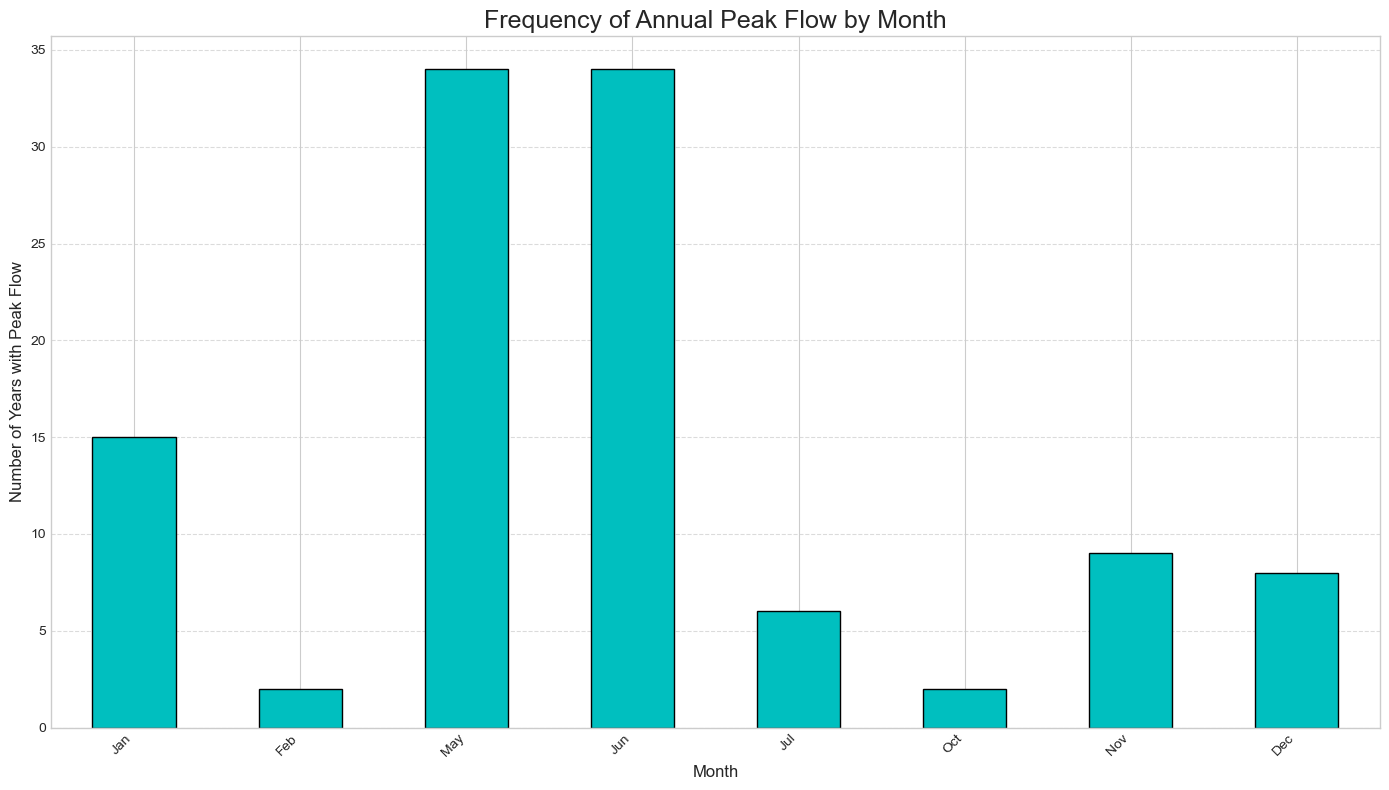

In [6]:
# --- 6. Visualize the Timing of Annual Peak Flows ---

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 8))

# Create the bar plot
peak_month_counts.plot(kind='bar', color='c', edgecolor='black')

# Add titles and labels for clarity
plt.title('Frequency of Annual Peak Flow by Month', fontsize=18)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Years with Peak Flow', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()